# Quixo Players - Results Collection and Analysis

The purpose of this notebook is:
1. To `test` the correctness of our code implementation for different classes and functions.
2. To `evaluate` the performance of our players against the baseline players.
3. To `investigate` their resulting in-game strategies.
4. To `graphically display` the results of our experiments.

In [2]:
from game import Move, Player, Game
from quixo import Quixo
from symmetry import SymmetryGenerator
from main import RandomPlayer, MyPlayer
from reinforcement_learning import MonteCarloPlayer
from minimax import MinimaxPlayer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Quixo Game

### Example match
In this example, we'll show the phases of a game of Quixo between two random players. We're using our extended class `Quixo(Game)` which allows us to have more control over the visualization of each game state.

> 👁️‍🗨️ This is done in order to verify that the extensions that we have applied are working as expected, without altering the game logic.

In [3]:
g = Quixo()
player1 = RandomPlayer()
player2 = RandomPlayer()
winner = g.play(player1, player2, verbose=True, debug=True)
print(f"Winner: Player {winner}")


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Number of possible actions: 44
Possible actions:  [((0, 0), <Move.BOTTOM: 1>), ((0, 4), <Move.TOP: 0>), ((0, 0), <Move.RIGHT: 3>), ((4, 0), <Move.LEFT: 2>), ((1, 0), <Move.BOTTOM: 1>), ((1, 0), <Move.LEFT: 2>), ((1, 0), <Move.RIGHT: 3>), ((1, 4), <Move.TOP: 0>), ((1, 4), <Move.LEFT: 2>), ((1, 4), <Move.RIGHT: 3>), ((0, 1), <Move.RIGHT: 3>), ((0, 1), <Move.TOP: 0>), ((0, 1), <Move.BOTTOM: 1>), ((4, 1), <Move.LEFT: 2>), ((4, 1), <Move.TOP: 0>), ((4, 1), <Move.BOTTOM: 1>), ((2, 0), <Move.BOTTOM: 1>), ((2, 0), <Move.LEFT: 2>), ((2, 0), <Move.RIGHT: 3>), ((2, 4), <Move.TOP: 0>), ((2, 4), <Move.LEFT: 2>), ((2, 4), <Move.RIGHT: 3>), ((0, 2), <Move.RIGHT: 3>), ((0, 2), <Move.TOP: 0>), ((0, 2), <Move.BOTTOM: 1>), ((4, 2), <Move.LEFT: 2>), ((4, 2), <Move.TOP: 0>), ((4, 2), <Move.BOTTOM: 1>), ((3, 0), <Move.BOTTOM: 1>), ((3, 0), <Move.LEFT: 2>), ((3, 0), <Move.RIGHT: 3>), ((3, 4), <Move.TOP: 0>), ((3, 4),

### Utility functions

In [3]:
def collect_results(player1, player2, n_games=100):
    """
    Collects the results of playing n_games between player1 and player2.
    Returns a dictionary with the number of wins for each player.
    e.g. {'Player 0': 50, 'Player 1': 50}
    """
    
    # 1. Initialize the results
    results = defaultdict(int)
    results[0] = 0
    results[1] = 0

    # 2. Play the games
    for _ in tqdm(range(n_games)):
        g = Quixo()
        winner = g.play(player1, player2, verbose=False, debug=False)
        results[winner] += 1
        
    return results

In [27]:
def plot_results(results: dict, player1: str, player2: str):
    """
    Plots the results of playing n_games between player1 and player2.
    """
    # 1. Extract player numbers and wins
    players = list(results.keys())
    wins = list(results.values())

    # 2. Create a bar plot
    plt.figure(figsize=(6,5))
    plt.bar(players, wins, color=['red', 'black'])
    plt.xticks(players, [player1, player2])
    plt.ylabel('Number of Wins')
    plt.title('Game Results')
    plt.show()

## MiniMax Player

The MiniMax player is a player that uses the MiniMax algorithm to choose the best move. It is a recursive algorithm that explores the game tree until it reaches a terminal state. It then evaluates the utility of each terminal state and propagates the values back up the tree. 

> ⚠️ The algorithm assumes that the opponent will play optimally.

### Performance Evaluation

In this section, we show the results of 2000 games between a MiniMax player (with depth=2) and a random player:
- 1000 games where the MiniMax player starts
- 1000 games where the MiniMax moves second

100%|██████████| 1000/1000 [07:36<00:00,  2.19it/s]


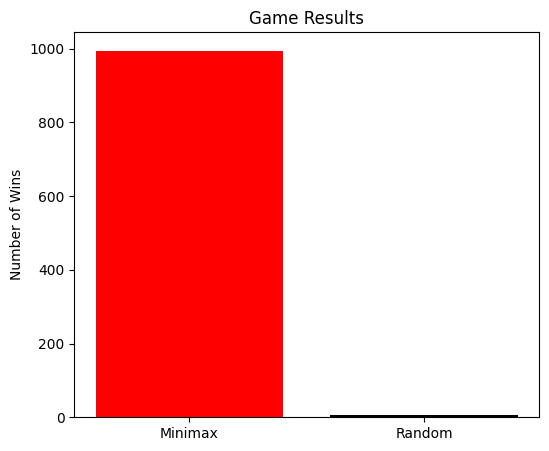

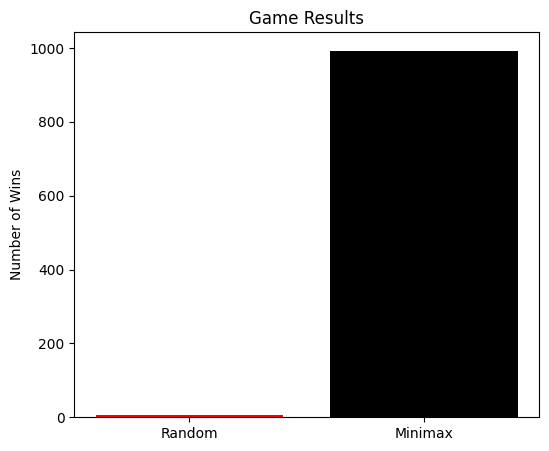

In [9]:
g = Quixo()
minimax_player = MinimaxPlayer(depth=2)
opponent = RandomPlayer()

# 1. Play 1000 games with Minimax moving first
res1 = collect_results(minimax_player, opponent, n_games=1000)

# 2. Play 1000 games with Minimax moving second
res2 = collect_results(opponent, minimax_player, n_games=1000)

# 3. Plot the results
plot_results(res1, 'Minimax', 'Random')
plot_results(res2, 'Random', 'Minimax')

In [13]:
print("❌ Results for Minimax moving first:")
print("Wins:", res1[0])
print("Losses:", res1[1])
print(f"Percentage of wins: {res1[0] / (res1[0] + res1[1]) * 100}%")

print("\n🔘 Results for Minimax moving second:")
print("Wins:", res2[1])
print("Losses:", res2[0])
print(f"Percentage of wins: {res2[1] / (res2[0] + res2[1]) * 100}%")

❌ Results for Minimax moving first:
Wins: 995
Losses: 5
Percentage of wins: 99.5%

🔘 Results for Minimax moving second:
Wins: 993
Losses: 7
Percentage of wins: 99.3%


### Strategy Analysis

In this section, we present an example of a full game between a MiniMax player and a random player. We want to show how the MiniMax player chooses its moves during the game, in order to spot any interesting patterns and weaknesses.

> ⚠️ Our hypothesis to explain the very few losses in the previous section is based on the fact that the Random player is not playing optimally. Therefore, it can potentially make unexpected moves that our heuristic function does not weight properly in its evaluation of the board state.

In [6]:
g = Quixo()
minimax_player = MinimaxPlayer(depth=2)
opponent = RandomPlayer()
g.play(minimax_player, opponent, verbose=True, debug=False)


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((0, 0), Move.BOTTOM)

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 moved ((1, 4), Move.TOP)

*****************
⬜ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((0, 0), Move.BOTTOM)

*****************
⬜ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 tried to move ((2, 2), Move.BOTTOM) but failed
Player 1 tried to move ((4, 3), Move.RIGHT) but failed
Player 1 moved ((0, 1), Move.RIGHT)

*****************
⬜ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ 🔘 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((1, 4), Move.LEFT)

*****************
⬜ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ 🔘 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 
❌ ❌ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 tried to move ((0, 4), Move.BOTTOM) but failed
Player 1 moved ((2, 4), Move.RIGHT)

*****************
⬜ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ 🔘 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ 

0

As we can see, the MiniMax player's strategy appears to be sound. Our player is able to win the game in few moves thanks to:
- **Corner prioritization** - it initially prioritizes the corners of the board as they provide more opportunities for creating winning sequences along rows, columns, and diagonals.
- **Building along different directions** - it builds along different directions in parallel in order to increase the chances of creating favorable sequences that cannot be easily blocked by the opponent.
- **Blocking the opponent** - along with building its own sequences, it also blocks the opponent's sequences in order to prevent them from winning the game.
- **4 in a line prioritization** - it prioritizes the creation of 4 in a line sequences in order to win the game as soon as possible.

> ⚠️ The heuristic function that we have implemented is not perfect. In fact, especially with a `depth <= 2`, it can lead to suboptimal moves. For example, it can prioritize the creation of a 4 in a line sequence withouth considering the eventuality of *having no more moves available* to complete the sequence in the next turn.

## Reinforcement Learning Player

### Symmetry Functionalities

In this section, we want to verify the correctness of our implementation of the `SymmetryGenerator` class. We do this by creating a specific board state and checking that the generated symmetries and actions are correct.

In [2]:
# 1. Build a new board with a state you want to test
board = np.ones((5, 5), dtype=np.uint8) * -1
board[0,1] = 1
board[0,4] = 1
board[2,4] = 1
board[3,0] = 0
board[4,0] = 0

# 2. Use the SymmetryGenerator to get all symmetries
symmetry_generator = SymmetryGenerator()
all_symmetries = symmetry_generator.board_get_symmetries(board)

# 3. Print all the resulting symmetries as full boards
print("All Symmetries:")
for label, state in all_symmetries:
    print(f"Transformation: {label}")
    print(state)

# 4. Find the lexicographically minimum state and its transformation label
print("\n\nLexicographically minimum state:")
transf_performed, base_state = symmetry_generator.get_base_state(board)
print(f"Transformation: {transf_performed}")
print(base_state)

# 5. Choose an action you want to test
from_pos = (1, 4)
slide = Move.RIGHT

# 6. Get the action in the lexicographically minimum state
print("\n\nAction in lexicographically minimum state:")
base_from_pos, base_slide = symmetry_generator.get_base_action(from_pos, slide, transf_performed)
print(f"From position: {base_from_pos}")
print(f"Slide: {base_slide}")

# 7. Retrieve the original action
print("\n\nOriginal action:")
original_from_pos, original_slide = symmetry_generator.get_original_action(base_from_pos, base_slide, transf_performed)
print(f"From position: {original_from_pos}")
print(f"Slide: {original_slide}")

All Symmetries:
Transformation: identity
[[-1  1 -1 -1  1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1  1]
 [ 0 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1]]
Transformation: rotate_90
[[ 1 -1  1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]
 [-1 -1 -1  0  0]]
Transformation: rotate_180
[[-1 -1 -1 -1  0]
 [-1 -1 -1 -1  0]
 [ 1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1  1 -1]]
Transformation: rotate_270
[[ 0  0 -1 -1 -1]
 [-1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1  1 -1  1]]
Transformation: reflect_horizontal
[[ 1 -1 -1  1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1 -1 -1 -1]
 [-1 -1 -1 -1  0]
 [-1 -1 -1 -1  0]]
Transformation: reflect_vertical
[[ 0 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1]
 [-1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1]
 [-1  1 -1 -1  1]]
Transformation: reflect_diagonal
[[-1 -1 -1  0  0]
 [ 1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [ 1 -1  1 -1 -1]]
Transformation: reflect_antidiagonal
[[ 0  0 -1 -1 -1]
 [-1 -1 -1 -1  1]
 [-1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1]
 [-1 -1  1 -1  1]]


Lexicograph

### Training and Evaluation

In this section, we show the results of the training of our Reinforcement Learning player. We trained the player for a total of 500000 games against a random player. We then evaluated its performance against the baseline players.

In [9]:
# PARAMETERS
epsilon=1         # exploration rate
e_decay=0.99999   # exploration decay rate
e_min=0.5         # minimum exploration rate
alpha=0.2         # learning rate
gamma=0.9         # discount factor

# GUIDED EXTENSION
guided_extension=False
opening_moves=5

g = Quixo()
mc_player = MonteCarloPlayer(epsilon=epsilon, e_decay=e_decay, e_min=e_min, alpha=alpha, gamma=gamma, guided_extension=guided_extension, opening_moves=opening_moves)
opponent = RandomPlayer()

In [ ]:
training_steps = [100, 5000, 10000, 50000, 100000, 500000]
training_results_move_first = []
training_results_move_second = []

previous_steps = 0

for steps in tqdm(training_steps):
    
    # 1. Train the RL-agent against the opponent for a given number of steps
    mc_player.train(steps - previous_steps)
    previous_steps = steps

    # 2. EVAL: Play 100 games against the opponent making the first move
    results = collect_results(mc_player, opponent, n_games=100)
    training_results_move_first.append(results)

    # 3. EVAL: Play 100 games against the opponent making the second move
    results = collect_results(opponent, mc_player, n_games=100)
    training_results_move_second.append(results)

    # 4. Print the results
    print(f"Training steps: {steps}")
    print(f"❌ Results for MC moving first: wins = {training_results_move_first[-1][0]}, losses = {training_results_move_first[-1][1]}")
    print(f"🔘 Results for MC moving second: wins = {training_results_move_second[-1][1]}, losses = {training_results_move_second[-1][0]}")
    print(f"Q_table size: {len(mc_player.q_table)}")

100%|██████████| 1000/1000 [00:17<00:00, 56.97it/s]


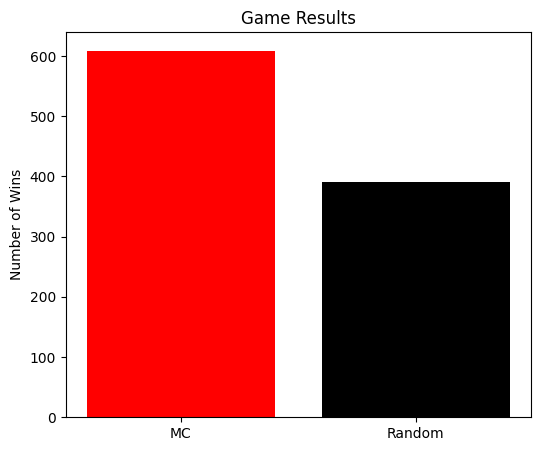

In [28]:
mc_player.guided_extension = False
results = collect_results(mc_player, opponent, n_games=1000)
plot_results(results, 'MC', 'Random')

### Guided Extension

 In this section, we want to show the results of our experiments with the `GuidedExtension` class. Even if the learned policy is not strong enough to learn a winning strategy for the entire game, we can see that it is instead able to learn a winning strategy for the first few moves of the game. In fact, it's very probable that the Q-values for the first few moves are accurately covered, as they are the ones that are most frequently visited during the training phase.

 We can therefore leverage this knowledge to create a new player that uses the learned policy to play the first 10 moves of the game, and then switches to the heuristic-based evaluation function to guide the final moves.

100%|██████████| 1000/1000 [00:36<00:00, 27.62it/s]


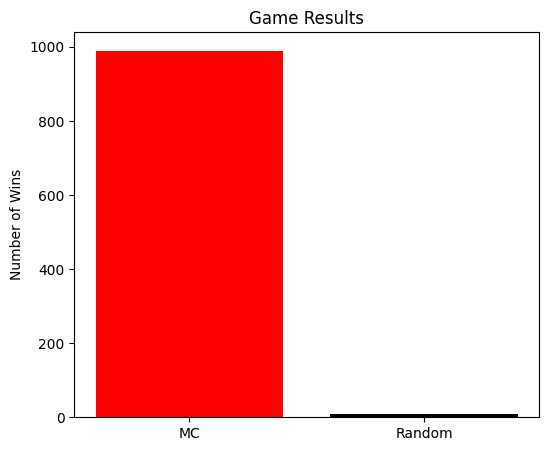

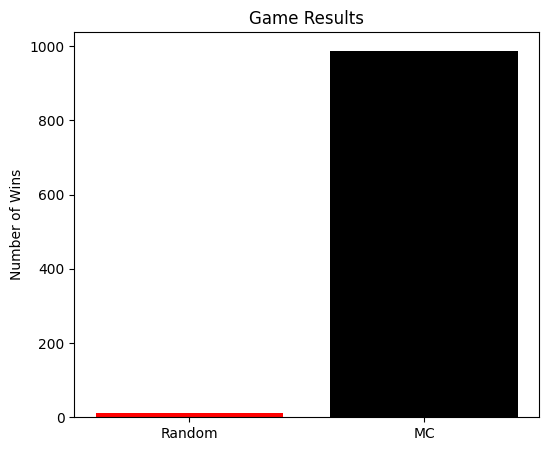

In [29]:
mc_player.guided_extension = True
mc_player.opening_moves = 10

results1 = collect_results(mc_player, opponent, n_games=1000)
results2 = collect_results(opponent, mc_player, n_games=1000)
plot_results(results1, 'MC', 'Random')
plot_results(results2, 'Random', 'MC')

### Strategy Analysis

In this section, we present an example of a full game between a Reinforcement Learning player and a random player. We want to show how the Reinforcement Learning player chooses its moves during the game, in order to spot any interesting patterns and weaknesses.

In [34]:
g = Quixo()
g.play(mc_player, opponent, verbose=True, debug=False)


*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((3, 4), Move.LEFT)

*****************
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 moved ((0, 2), Move.TOP)

*****************
🔘 ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((3, 0), Move.LEFT)

*****************
❌ 🔘 ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 tried to move ((2, 3), Move.LEFT) but failed
Player 1 tried to move ((1, 4), Move.BOTTOM) but failed
Player 1 tried to move ((4, 3), Move.RIGHT) but failed
Player 1 tried to move ((3, 3), Move.TOP) but failed
Player 1 moved ((4, 1), Move.TOP)

*****************
❌ 🔘 ⬜ ⬜ 🔘 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: ❌
Player 0 moved ((0, 1), Move.RIGHT)

*****************
❌ 🔘 ⬜ ⬜ 🔘 
⬜ ⬜ ⬜ ⬜ ❌ 
⬜ ⬜ ⬜ ⬜ ⬜ 
⬜ ⬜ ⬜ ⬜ ⬜ 
❌ ⬜ ⬜ ⬜ ⬜ 

Current player: 🔘
Player 1 moved ((0, 1), Move.BOTTOM)

************

0

As we can see, the Reinforcement Learning player's opening strategy appears to be very effective. It chooses a move that is not only optimal according to the heuristic function, but results in a winning sequence in the next turn. This is a clear example of how the learned policy is able to spot a scheme that is not easily recognizable by a human player.